In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import torch.optim as optim 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps
%matplotlib inline
from torch.autograd import Variable

#importing Fashion Mnist dataset
transform_list = transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean=[0.0], std=[1.0,]) ] )
mnist_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_list)
mnist_testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_list)

X_train = mnist_trainset.data.numpy()
y_train = mnist_trainset.targets.numpy()
X_test = mnist_testset.data.numpy()
y_test = mnist_testset.targets.numpy()

X_train = X_train[:60000,:,:]
y_train = y_train[:60000]
X_test = X_test[:10000,:,:]
y_test = y_test[:10000]

print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)


(60000,)
(60000, 28, 28)
(10000,)
(10000, 28, 28)


In [2]:
def neural_network_with_CCP(X_train,X_test,y_train,y_test,input_dim,hidden_layer,output_layer,learning_rate,epochs,kf):
    X_train_nn = Variable(torch.from_numpy(X_train)).float()
    y_train_nn = Variable(torch.from_numpy(y_train)).long()
    X_test_nn  = Variable(torch.from_numpy(X_test)).float()
    y_test_nn  = Variable(torch.from_numpy(y_test)).long()
    
    class N_Net( nn.Module ):    
        def __init__(self):
            super(N_Net, self).__init__()
            self.layers = nn.Sequential( 
                nn.Flatten(), 
                nn.Linear(input_dim,hidden_layer[0]),
                nn.ReLU(),
                nn.Linear(hidden_layer[0], hidden_layer[1]), 
                nn.ReLU(),
                nn.Linear(hidden_layer[1], output_layer),
                nn.LogSoftmax(dim=1))
        
        def forward(self, x):
            x1 = self.layers(x)
            return x1
        
    n_Net = N_Net()
    
    #cross conformal prediction for Neural Network
    def ccp(X_train,X_test,y_train,kf):
        rank_of_folds = None
        for rest_i, fold_i in kf.split(X_train):
            X_rest, X_fold = X_train[rest_i], X_train[fold_i]
            y_rest, y_fold = y_train[rest_i], y_train[fold_i] 
            c_score_fold = n_Net(X_fold).numpy()
            c_score_one = n_Net(X_test).numpy()
            rank_fold = None
            for each in c_score_one:
                rank = np.sum(c_score_fold<each,0)+1
                if rank_fold is None:
                    rank_fold = [rank-1]
                else:
                    rank_fold = np.vstack((rank_fold,[rank-1]))
            if rank_of_folds is None:
                rank_of_folds = [rank_fold]
            else:
                rank_of_folds = np.vstack((rank_of_folds, [rank_fold]))
        sum_ranks = np.sum(rank_of_folds,0)
        p_values = (sum_ranks+1)/len(y_train)
        return(p_values)   

    loss_train = np.zeros((epochs,))
    loss_test = np.zeros((epochs,))
    accuracy_test_CCP_True = np.zeros((epochs,))
    accuracy_test_NN_True = np.zeros((epochs,))
    optimizer1 = optim.RMSprop( n_Net.parameters(), lr=learning_rate )
    loss_function = nn.CrossEntropyLoss() 
    true_test_label = y_test_nn.numpy()
    error_train = 0

    for epoch in range(epochs):
        total_train = 0
        error_train = 0
        optimizer1.zero_grad()
        y_pred_train_NN = n_Net(X_train_nn)
        loss_NN = loss_function(y_pred_train_NN, y_train_nn)     
        total_train += y_train_nn.size(0)
        loss_t = loss_NN.item()
        loss_train[epoch] = 100 * loss_t / total_train
        loss_NN.backward()
        optimizer1.step()
        correct_NN = 0 
        correct_CPP = 0 
        total = 0 
        error_test = 0
        cnn_accuracy = 0
        ccp_accuracy = 0
        
        with torch.no_grad():
            y_pred_NN = n_Net(X_test_nn).numpy()
            y_p_values_CCP = ccp(X_train_nn,X_test_nn,y_train_nn,kf)
            y_hat_CCP = np.argmax(y_p_values_CCP,axis=1)
            y_pred_NN_loss = n_Net(X_test_nn)
            loss_test_CNN = loss_function(y_pred_NN_loss, y_test_nn)
            error_test = loss_test_CNN.item()
            y_predicted_NN = np.argmax(y_pred_NN,axis = 1)
            correct_NN = np.mean(y_predicted_NN==true_test_label)
            correct_CPP = np.mean(y_hat_CCP==true_test_label)
            total += y_test_nn.size(0)
        accuracy_test_NN_True[epoch] = correct_NN
        accuracy_test_CCP_True[epoch] = correct_CPP
        loss_test[epoch] = 100 * error_test / total
           
    return loss_train,loss_test,accuracy_test_NN_True,accuracy_test_CCP_True

Cross validation of stopping rule, learning rate, and the numbers of hidden neurons at various levels. 

In [3]:
#learning rate analysis
from sklearn.model_selection import KFold 
ran_state = 301
kf = KFold(shuffle=True, random_state=ran_state) 

lr_list = [0.1, 0.01, 0.001, 0.0001, 0.00001]
input_dim = 28*28
hidden_layer = [300,200]
output_layer = 10
epochs = 50

loss_train_lr = np.zeros((len(lr_list,)))
loss_test_lr = np.zeros((len(lr_list,)))
accuracy_test_NN_True_lr = np.zeros((len(lr_list,)))
accuracy_test_CCP_True_lr = np.zeros((len(lr_list,)))
test_accuracy_list = np.zeros((len(lr_list,),epochs))
test_loss_list = np.zeros((len(lr_list,),epochs))

for index, i in enumerate(lr_list):
    print(i)
    loss_train = np.zeros((epochs,))
    loss_test = np.zeros((epochs,))
    accuracy_test_NN_True = np.zeros((epochs,))
    accuracy_test_CCP_True = np.zeros((epochs,))

    loss_train, loss_test, accuracy_test_NN_True, accuracy_test_CCP_True = neural_network_with_CCP(X_train,X_test,y_train,y_test,
                                                                           input_dim,hidden_layer,output_layer,i,epochs,kf)
    loss_train_lr[index] = loss_train[-1]
    loss_test_lr[index] = loss_test[-1]
    accuracy_test_NN_True_lr[index] = max(accuracy_test_NN_True)
    print(accuracy_test_CCP_True[-1])
    accuracy_test_CCP_True_lr[index] = max(accuracy_test_CCP_True)
    test_accuracy_list[index] = accuracy_test_CCP_True
    test_loss_list[index] = loss_train

0.1
0.1009
0.01
0.3236
0.001
0.7314
0.0001
0.7701
1e-05
0.6248


In [4]:
print(test_loss_list[0])

[2.69773706e-02 4.82900427e+05 1.10720846e+00 4.33439941e+01
 2.81247754e+01 4.31332245e-01 5.60947800e-02 1.44306723e-02
 9.57125425e-03 7.74475733e-03 6.74256484e-03 6.19708220e-03
 5.53074797e-03 5.21613797e-03 4.97685472e-03 4.80901440e-03
 4.68194326e-03 4.58793004e-03 4.52274442e-03 4.46977099e-03
 4.43156600e-03 4.40054854e-03 4.36832587e-03 4.34079409e-03
 4.31405624e-03 4.28813299e-03 4.26331202e-03 4.24263557e-03
 4.22513445e-03 4.21032866e-03 4.19623971e-03 4.18674906e-03
 4.17623123e-03 4.16901787e-03 4.15967981e-03 4.14987842e-03
 4.14069295e-03 4.13191477e-03 4.12277619e-03 4.11459128e-03
 4.10586953e-03 4.09905632e-03 4.09178734e-03 4.08493360e-03
 4.07969991e-03 4.07469630e-03 4.06959017e-03 4.06451861e-03
 4.05964375e-03 4.05447761e-03]


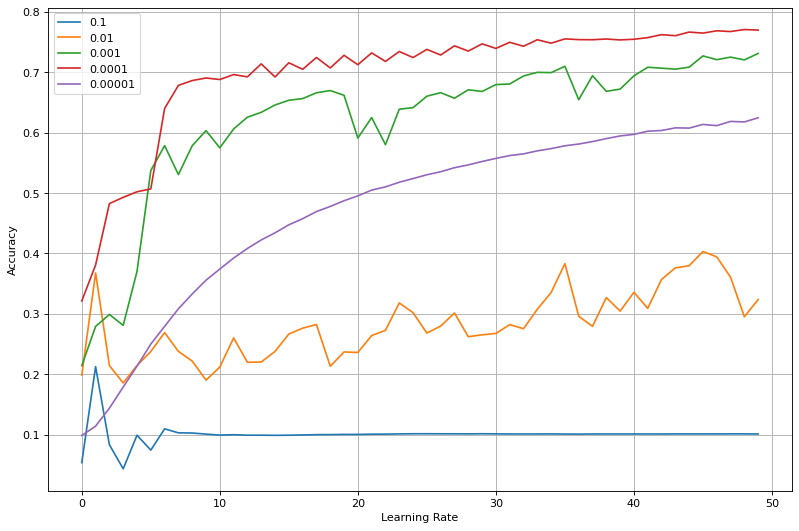

In [5]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)
epoch_no = list(range(0, epochs))
plt.plot(epoch_no, test_accuracy_list[0])
plt.plot(epoch_no, test_accuracy_list[1])
plt.plot(epoch_no, test_accuracy_list[2])
plt.plot(epoch_no, test_accuracy_list[3])
plt.plot(epoch_no, test_accuracy_list[4])
plt.legend(('0.1','0.01','0.001','0.0001','0.00001'))
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.grid()

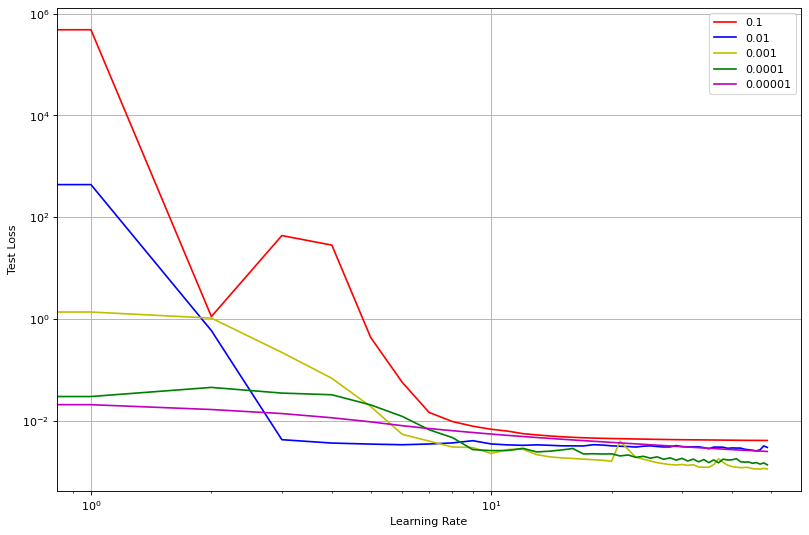

In [6]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)
epoch_no = list(range(0, epochs))
plt.loglog(epoch_no, test_loss_list[0], color ='r')
plt.loglog(epoch_no, test_loss_list[1], color = 'b')
plt.loglog(epoch_no, test_loss_list[2], color ='y')
plt.loglog(epoch_no, test_loss_list[3], color = 'g')
plt.loglog(epoch_no, test_loss_list[4], color = 'm')
plt.legend(('0.1','0.01','0.001','0.0001','0.00001'))
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss')
plt.grid()

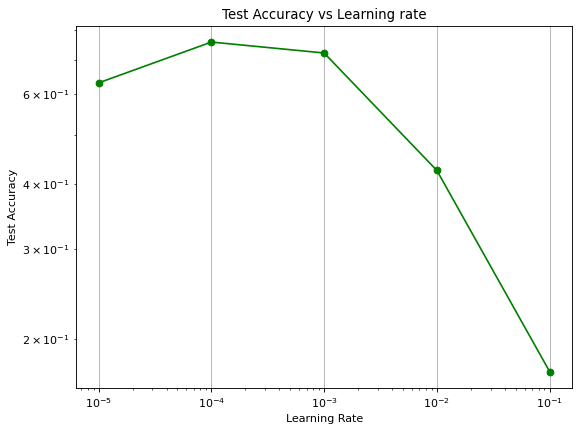

In [7]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.loglog(lr_list, accuracy_test_NN_True_lr,'go-')
plt.title(('Test Accuracy vs Learning rate')) 
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')
plt.grid()

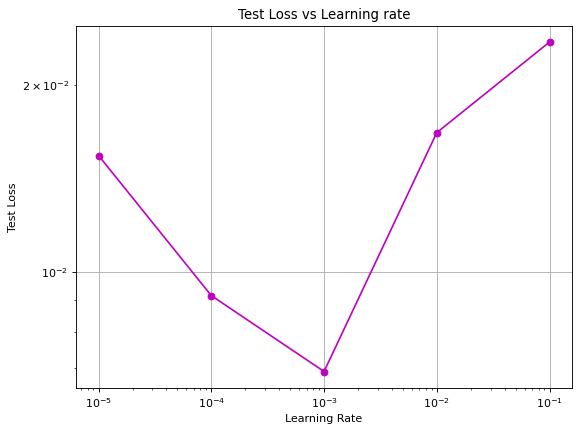

In [8]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.loglog(lr_list, loss_test_lr,'mo-')
plt.title(('Test Loss vs Learning rate')) 
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss')
plt.grid()

In [18]:
from tqdm import tqdm

In [22]:
#analysis of change of accuracy of the model with the change in the stopping rule or the number of epochs
input_dim = 28*28
hidden_layer = [300,200]
output_layer = 10
lr = 0.0001
epoch_list = [10, 50, 100, 150, 200]

loss_train_epoch = np.zeros((len(epoch_list,)))
loss_test_epoch = np.zeros((len(epoch_list,)))
accuracy_test_NN_True_epoch = np.zeros((len(epoch_list,)))
accuracy_test_CCP_True_epoch = np.zeros((len(epoch_list,)))

for index, i in enumerate(tqdm(epoch_list)):
    print(i)
    loss_train = np.zeros((i,))
    loss_test = np.zeros((i,))
    accuracy_test_NN_True = np.zeros((i,))
    accuracy_test_CCP_True = np.zeros((i,))

    loss_train, loss_test, accuracy_test_NN_True, accuracy_test_CCP_True = neural_network_with_CCP(X_train,X_test,y_train,y_test,
                                                                                               input_dim,hidden_layer,output_layer,lr,i,kf)
    loss_train_epoch[index] = loss_train[-1]
    loss_test_epoch[index] = loss_test[-1]
    accuracy_test_NN_True_epoch[index] = accuracy_test_NN_True[-1]
    print(accuracy_test_CCP_True[-1])
    accuracy_test_CCP_True_epoch[index] = accuracy_test_CCP_True[-1]

  0%|          | 0/5 [00:00<?, ?it/s]

10


 20%|██        | 1/5 [03:43<14:54, 223.67s/it]

0.6581
50


 40%|████      | 2/5 [22:04<24:20, 486.72s/it]

0.7677
100


 60%|██████    | 3/5 [58:47<33:23, 1001.77s/it]

0.7987
150


 80%|████████  | 4/5 [1:54:46<28:28, 1708.98s/it]

0.8236
200


100%|██████████| 5/5 [3:13:36<00:00, 2323.23s/it]

0.8222


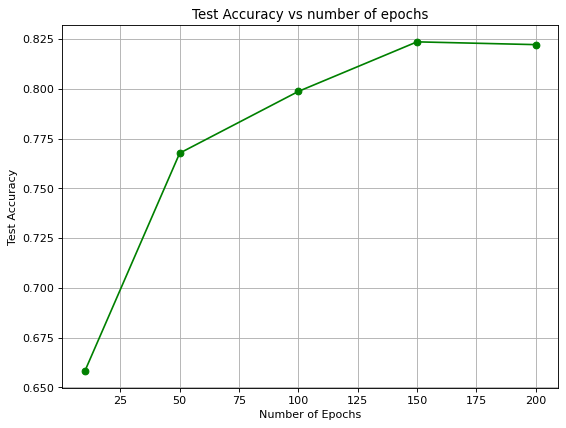

In [23]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.plot(epoch_list, accuracy_test_CCP_True_epoch,'go-')
plt.title(('Test Accuracy vs number of epochs')) 
plt.xlabel('Number of Epochs')
plt.ylabel('Test Accuracy')
plt.grid()

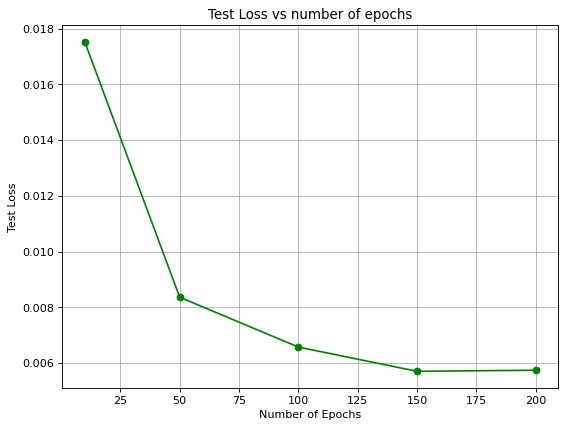

In [24]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.plot(epoch_list, loss_test_epoch,'go-')
plt.title(('Test Loss vs number of epochs')) 
plt.xlabel('Number of Epochs')
plt.ylabel('Test Loss')
plt.grid()

In [25]:
#analysis of change of accuracy of the model with the change in the number of hidden neurons at various level
input_dim = 28*28
hidden_layer_list = [[300,200],[200,200],[200,150],[200,100],[50,20]]
hidden_layer_plot = [500,400,350,300,70]
output_layer = 10
lr = 0.0001
epochs = 50

loss_train_hl = np.zeros((len(hidden_layer_list,)))
loss_test_hl = np.zeros((len(hidden_layer_list,)))
accuracy_test_NN_True_hl = np.zeros((len(hidden_layer_list,)))
accuracy_test_CCP_True_hl = np.zeros((len(hidden_layer_list,)))
test_accuracy_list_hl = np.zeros((len(lr_list,),epochs))
test_loss_list_hl = np.zeros((len(lr_list,),epochs))

for index, i in enumerate(hidden_layer_list):
    print(i)
    loss_train = np.zeros((epochs,))
    loss_test = np.zeros((epochs,))
    accuracy_test_NN_True = np.zeros((epochs,))
    accuracy_test_CCP_True = np.zeros((epochs,))

    loss_train, loss_test, accuracy_test_NN_True, accuracy_test_CCP_True = neural_network_with_CCP(X_train,X_test,y_train,y_test,
                                                                                               input_dim,i,output_layer,lr,epochs,kf)
    loss_train_hl[index] = loss_train[-1]
    loss_test_hl[index] = loss_test[-1]
    accuracy_test_NN_True_hl[index] = accuracy_test_NN_True[-1]
    print(accuracy_test_CCP_True[-1])
    accuracy_test_CCP_True_hl[index] = accuracy_test_CCP_True[-1]
    test_accuracy_list_hl[index] = accuracy_test_CCP_True
    test_loss_list_hl[index] = loss_train

[300, 200]
0.7654
[200, 200]
0.7607
[200, 150]
0.7491
[200, 100]
0.7565
[50, 20]
0.6225


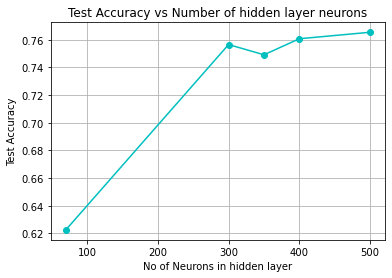

In [26]:
plt.plot(hidden_layer_plot, accuracy_test_CCP_True_hl,'co-')
plt.title(('Test Accuracy vs Number of hidden layer neurons')) 
plt.xlabel('No of Neurons in hidden layer')
plt.ylabel('Test Accuracy')
plt.grid()

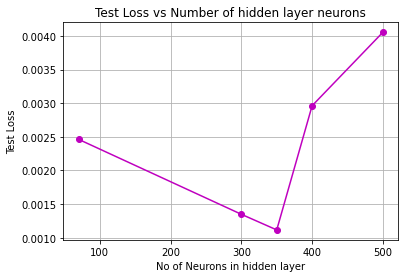

In [27]:
plt.plot(hidden_layer_plot, loss_train_lr,'mo-')
plt.title(('Test Loss vs Number of hidden layer neurons')) 
plt.xlabel('No of Neurons in hidden layer')
plt.ylabel('Test Loss')
plt.grid()

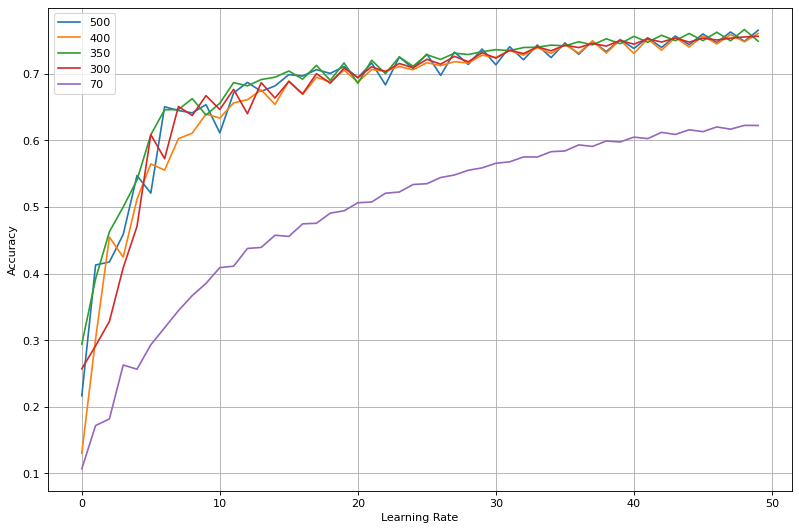

In [28]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)
epoch_no = list(range(0, epochs))
plt.plot(epoch_no, test_accuracy_list_hl[0])
plt.plot(epoch_no, test_accuracy_list_hl[1])
plt.plot(epoch_no, test_accuracy_list_hl[2])
plt.plot(epoch_no, test_accuracy_list_hl[3])
plt.plot(epoch_no, test_accuracy_list_hl[4])
plt.legend(('500','400','350','300','70'))
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.grid()

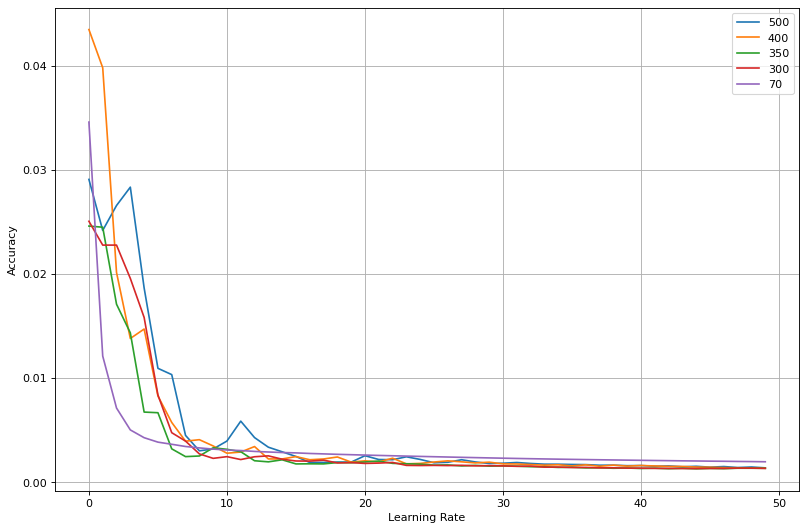

In [29]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)
epoch_no = list(range(0, epochs))
plt.plot(epoch_no, test_loss_list_hl[0])
plt.plot(epoch_no, test_loss_list_hl[1])
plt.plot(epoch_no, test_loss_list_hl[2])
plt.plot(epoch_no, test_loss_list_hl[3])
plt.plot(epoch_no, test_loss_list_hl[4])
plt.legend(('500','400','350','300','70'))
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.grid()